<a href="https://colab.research.google.com/github/Bast1-py/Experience-Developing-Projects/blob/main/Emotion_Detection_System_using_Advanced_NLP_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "text.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "nelgiriyewithana/emotions",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df.head()

/tmp/ipython-input-3058561043.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 15.7M/15.7M [00:00<00:00, 85.5MB/s]

Extracting zip of text.csv...


,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
# print(datasets.__version__)

In [ ]:
# pip install --upgrade datasets

In [ ]:
# pip install --upgrade transformers

In [ ]:
import os
import torch
import datasets
import re
import string
import unicodedata
import time
import spacy
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from datasets import Dataset
from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [ ]:
df['label'].unique()

array([4, 0, 2, 1, 5, 3])

In [ ]:
emo_map = {0:'Sadness',
           1:'Joy',
           2:'Love',
           3:'Anger',
           4:'Fear',
           5:'Surprise'}
df['label_modif'] = df['label'].map(emo_map)
df

,text,label,label_modif
0,i just feel really helpless and heavy hearted,4,Fear
1,ive enjoyed being able to slouch about relax a...,0,Sadness
2,i gave up my internship with the dmrg and am f...,4,Fear
3,i dont know i feel so lost,0,Sadness
4,i am a kindergarten teacher and i am thoroughl...,4,Fear
...,...,...,...
416804,i feel like telling these horny devils to find...,2,Love
416805,i began to realize that when i was feeling agi...,3,Anger
416806,i feel very curious be why previous early dawn...,5,Surprise
416807,i feel that becuase of the tyranical nature of...,3,Anger


In [ ]:
def check_values(df):
  data = []
  for col in df.columns:
    data.append([col, \
                 df[col].dtype, \
                 df[col].isna().sum(), \
                 round(100 * (df[col].isna().sum() / len(df)), 2), \
                 df[col].nunique(), \
                 df[col].unique()
                 ])
  return pd.DataFrame(columns=["Columns",
                                 "Dtype",
                                 "Null",
                                 "NullPercentage",
                                 "Unique",
                                 "Values"], data=data)

In [ ]:
check_values(df)

,Columns,Dtype,Null,NullPercentage,Unique,Values
0,text,object,0,0.0,393822,[i just feel really helpless and heavy hearted...
1,label,int64,0,0.0,6,"[4, 0, 2, 1, 5, 3]"
2,label_modif,object,0,0.0,6,"[Fear, Sadness, Love, Joy, Surprise, Anger]"


In [ ]:
def printData(data):
  for item in data:
    print(item)
printData(df['text'])

Output streaming akan dipotong hingga 5000 baris terakhir.
i were feeling pretty ehhhh about it
i feel like this was one of those tender mercies of the lord because as we sat waiting for the meeting to start i was able to focus on why i was there and prepare myself to listen to the speakers
i feel bitchy right now this early in the morning after having such a late night
ive said this before i strongly believe in the need for reviews especially for new authors so i feel i need to do my part in supporting that by giving them
i got to meet a bunch of amazing crafty people that i feel extremely honored to now call my friend and i will see you ladies on saturday
i didn t feel superior
i said in some recent interviews we will have two guests on the next alcest album and today i feel glad to reveal the first one
i feel blessed to have someone like him to look up to and proud of all he has done for our country
i feel i need more summer but before the melancholy sets in i realize i can only get

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         416809 non-null  object
 1   label        416809 non-null  int64 
 2   label_modif  416809 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.5+ MB


# Pre-processing text

## 1. Handling Missing Value

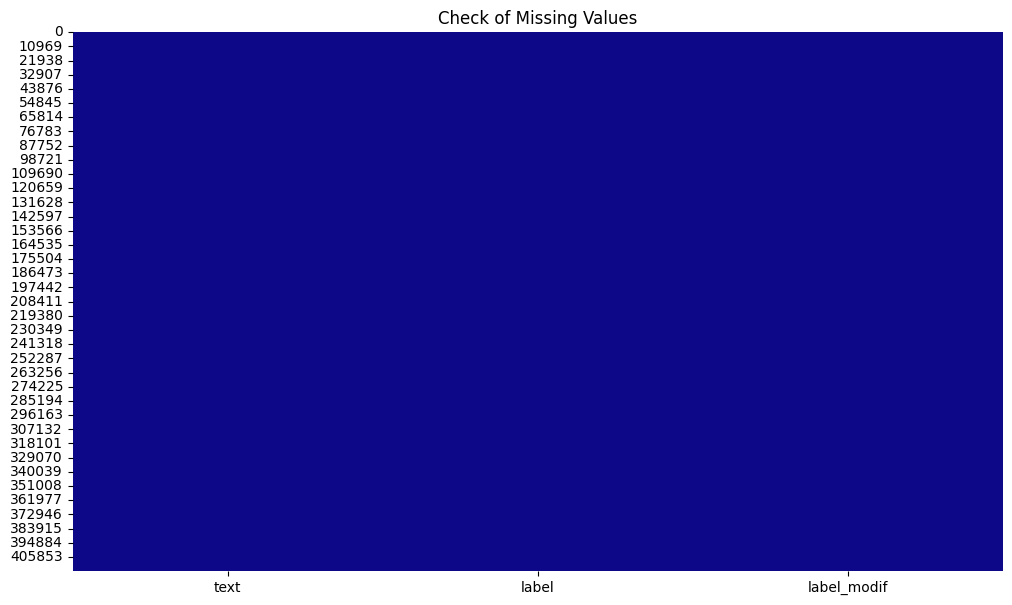

In [ ]:
plt.figure(figsize=(12,7))
sns.heatmap(df.isnull(), cbar=False, cmap='plasma')
plt.title('Check of Missing Values')
plt.show()

## 2. Handling Duplicate rows

In [ ]:
dup = df.duplicated()
num_dup = dup.sum()
print(f'Jumlah baris yang duplikat = {num_dup}')

Jumlah baris yang duplikat = 686


In [ ]:
df = df.drop_duplicates()
print(f'Jumlah baris setelah di drop baris yang duplikat = {df.shape}')

Jumlah baris setelah di drop baris yang duplikat = (416123, 3)


In [ ]:
df['text_length'] = df['text'].apply(len)
print(df['text_length'].describe())

count    416123.000000
mean         97.102662
std          56.176302
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: text_length, dtype: float64


In [ ]:
df['label_modif'].value_counts()

,count
label_modif,
Joy,140779
Sadness,120989
Anger,57235
Fear,47664
Love,34497
Surprise,14959


In [ ]:
df_analisis = df.copy()

In [ ]:
df_analisis

,text,label,label_modif,text_length
0,i just feel really helpless and heavy hearted,4,Fear,45
1,ive enjoyed being able to slouch about relax a...,0,Sadness,234
2,i gave up my internship with the dmrg and am f...,4,Fear,63
3,i dont know i feel so lost,0,Sadness,26
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,222
...,...,...,...,...
416804,i feel like telling these horny devils to find...,2,Love,132
416805,i began to realize that when i was feeling agi...,3,Anger,111
416806,i feel very curious be why previous early dawn...,5,Surprise,90
416807,i feel that becuase of the tyranical nature of...,3,Anger,222


## 3. Data Visualization For Show Distribution of Text Length

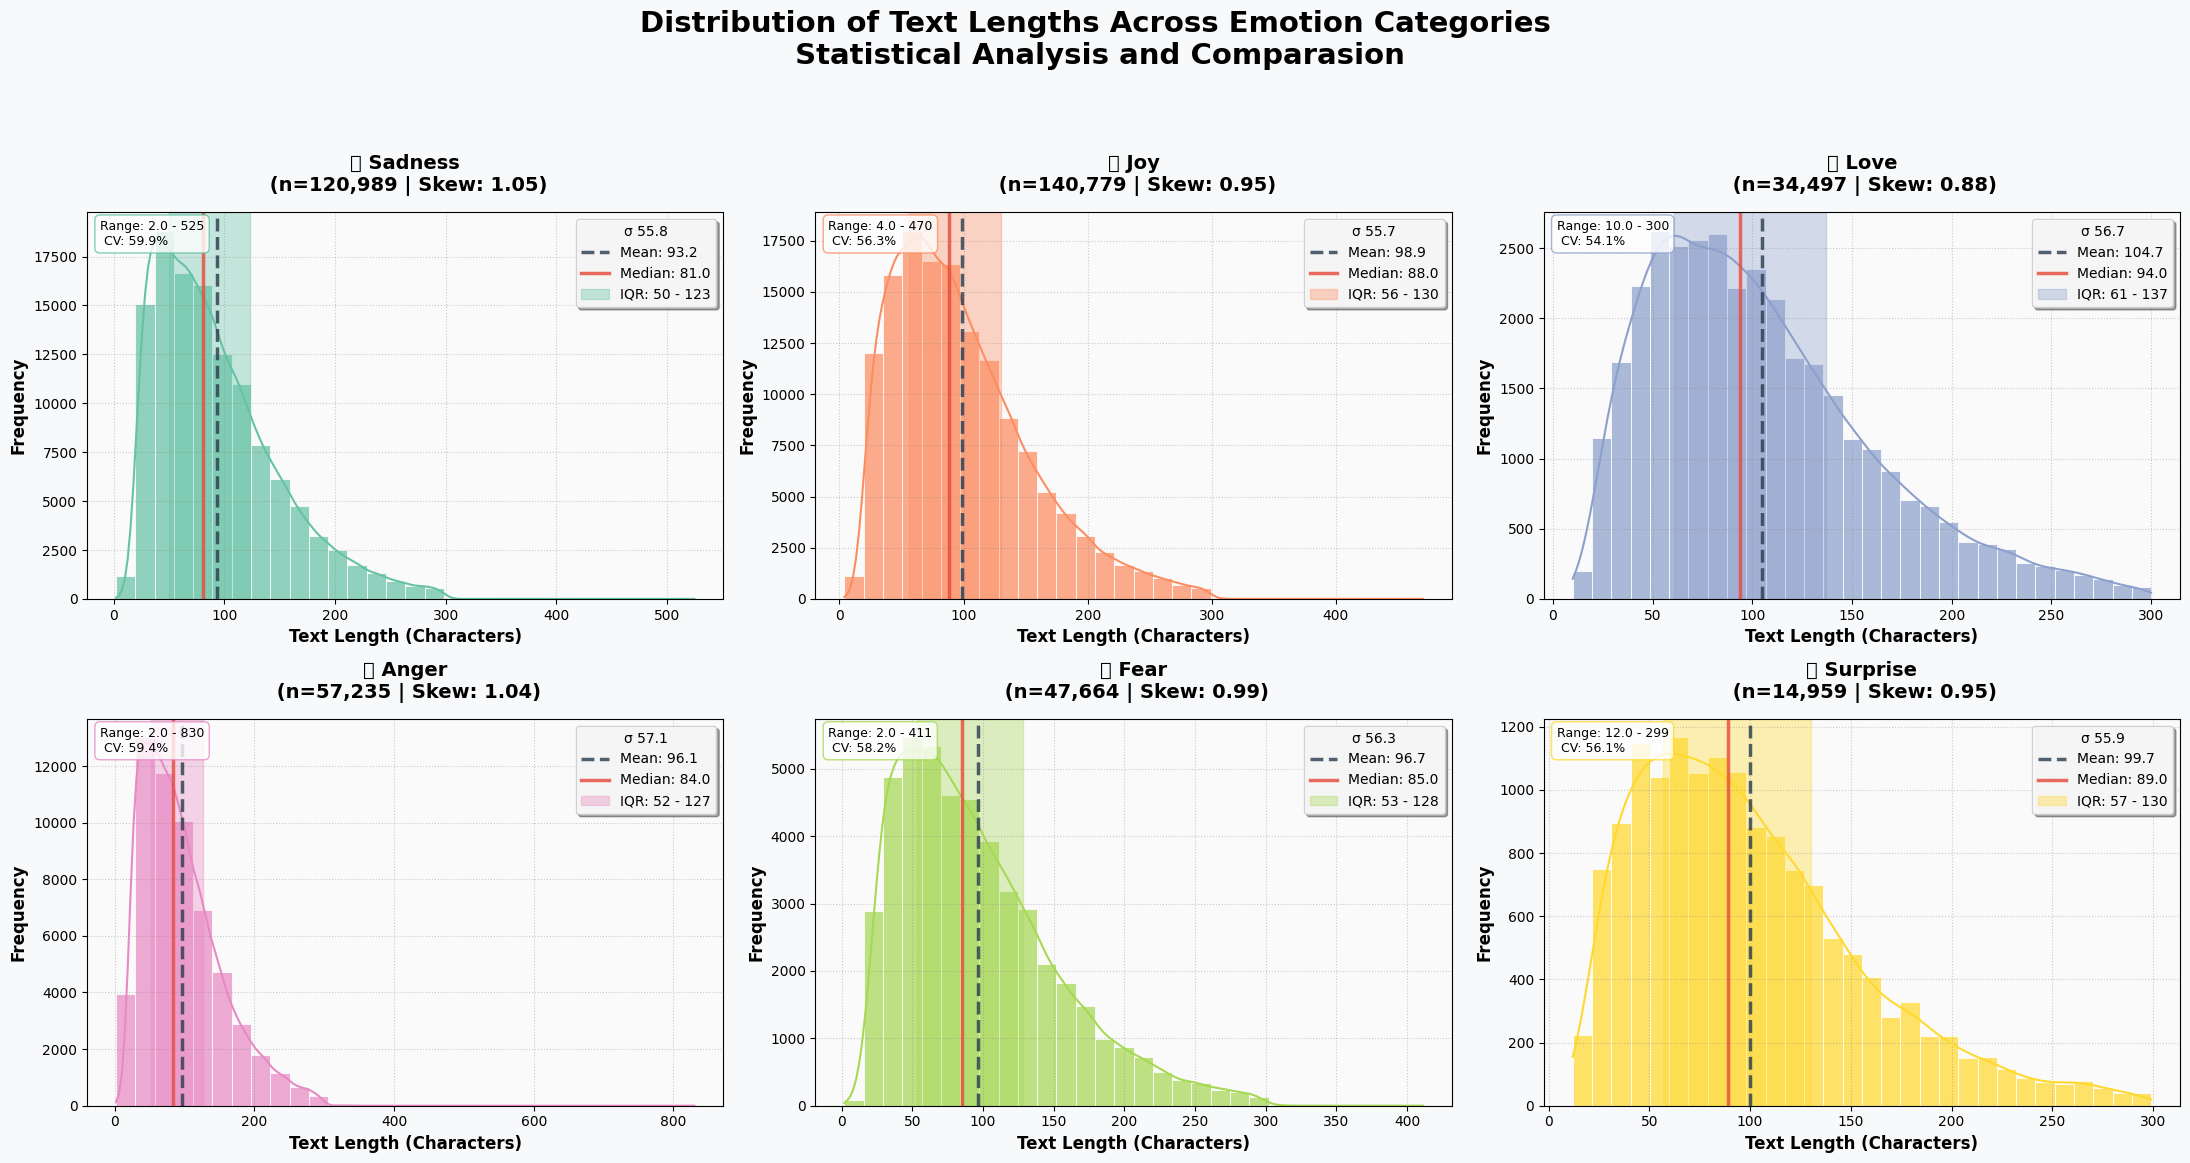

In [ ]:
# Set Enhanced Style
plt.style.use('default')
sns.set_palette('husl')

# Create Figure With Improved Layout
fig, axes = plt.subplots(2,3, figsize=(22,12))
axes = axes.flatten()

# Define modern color palette
colors = sns.color_palette('Set2', 6)

# Track Global Statistics for Comparasion
all_stats = []


for label, ax in zip(range(6), axes):
  text_lengths = df_analisis[df_analisis['label'] == label]['text'].str.len()

  # Calculate Comprehensive Statistics
  mean_len = text_lengths.mean()
  median_len = text_lengths.median()
  std_len = text_lengths.std()
  q25 = text_lengths.quantile(0.25)
  q75 = text_lengths.quantile(0.75)
  skewness = text_lengths.skew()


  # Store Stats For Summary
  all_stats.append({'Emotions': emo_map[label],
                    'Count': len(text_lengths),
                    'Mean': mean_len,
                    'Median': median_len,
                    'Standard Deviation': std_len,
                    'Skewness': skewness})


  # Create Enhanced Histogram With KDE
  sns.histplot(text_lengths,
               bins=30,
               color=colors[label],
               ax=ax,
               kde=True,
               alpha=0.72,
               edgecolor='white',
               linewidth=0.55)


  # Add Statistical Lines With Improved Styling
  ax.axvline(mean_len,
             color='#2c3e50',
             linestyle='--',
             linewidth=2.5,
             alpha=0.82,
             label=f'Mean: {mean_len:.1f}')
  ax.axvline(median_len,
             color='#e74c3c',
             linestyle='-',
             linewidth=2.5,
             alpha=0.82,
             label=f'Median: {median_len:.1f}')


  # Add Quartile Shading
  ax.axvspan(q25, q75, alpha=0.36, color=colors[label], label=f'IQR: {q25:.0f} - {q75:.0f}')


  # Enhanced Title With Sample Size And Skewness Indicator
  skew_indicator = "📊" if abs(skewness) < 0.5 else "📈" if skewness > 0 else "📉"
  ax.set_title(f'{skew_indicator} {emo_map[label]}\n (n={len(text_lengths):,} | Skew: {skewness:.2f})',
               fontsize=14,
               fontweight='bold',
               pad=15)


  # Improved Axis Labels And Formatting
  ax.set_xlabel('Text Length (Characters)',
                fontsize=12,
                fontweight='semibold')
  ax.set_ylabel('Frequency',
                fontsize=12,
                fontweight='semibold')


  # Enhanced Legend
  legend = ax.legend(title=f'σ {std_len:.1f}',
                     loc='upper right',
                     frameon=True,
                     fancybox=True,
                     shadow=True,
                     fontsize=10)

  legend.get_frame().set_facecolor('white')
  legend.get_frame().set_alpha(0.9)


  # subtle grid
  ax.grid(True, linestyle=':', alpha=0.4, color='gray')
  ax.set_facecolor('#fafafa')


  # format x-axis for better readability
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))


  # Add Text Box With Key Statistics
  stats_text = f'Range: {text_lengths.min():.1f} - {text_lengths.max():.0f}\n CV: {(std_len/mean_len) * 100:.1f}%'
  ax.text(0.02, 0.98, stats_text,
          transform=ax.transAxes,
          verticalalignment='top',
          bbox=dict(boxstyle='round,pad=0.4',
                    facecolor='white',
                    alpha=0.8,
                    edgecolor=colors[label]),
          fontsize=9)



# Enhanced Main Title
plt.suptitle('Distribution of Text Lengths Across Emotion Categories\n Statistical Analysis and Comparasion',
               fontsize=21,
               fontweight='bold',
               y=0.985)


# Improved Layout
plt.tight_layout(rect=[0, 0.02, 1, 0.94])


# Add Subtle background
fig.patch.set_facecolor('#f8f9fa')
plt.show()

### Statistical Analysis and Report

In [ ]:
# Report Comprehensive Summary Statistics
print('\n' + '='*100)
print('Comprehensive Text Length Analysis By Emotion')
print('='*100)

stats_df = pd.DataFrame(all_stats)
stats_df = stats_df.round(2)

print(f"\n{'Emotion':<12} {'Count':<8} {'Mean':<8} {'Median':<8} {'Std':<8} {'Skewness':<10}")
print("-" * 100)
for _, row in stats_df.iterrows():
    print(f"{row['Emotions']:<12} {row['Count']:<8} {row['Mean']:<8} {row['Median']:<8} {row['Standard Deviation']:<8} {row['Skewness']:<10}")
print('\n')



# Overall Statistics
overall_mean = df_analisis['text'].str.len().mean()
overall_std = df_analisis['text'].str.len().std()
print(f'\nOverall Dataset:')
print(f'Total Samples = {len(df_analisis):,}')
print(f'Overall Mean Length = {overall_mean:.2f} characters')
print(f'Overall Standard Deviation = {overall_std:.2f} characters')
print(f'Coefficient of Variation = {(overall_std/overall_mean)*100:.2f}%')
print('='*100)


# Identify Insights
max_mean_emotion = stats_df.loc[stats_df['Mean'].idxmax(), 'Emotions']
min_mean_emotion = stats_df.loc[stats_df['Mean'].idxmin(), 'Emotions']
most_variable = stats_df.loc[stats_df['Standard Deviation'].idxmax(), 'Emotions']
most_skewed = stats_df.loc[stats_df['Skewness'].abs().idxmax(), 'Emotions']

print('\n')
print(f'\nKey Insights:')
print(f'Longest Text On Average: {max_mean_emotion}')
print(f'Shortest Texts On Average: {min_mean_emotion}')
print(f'Most Variable Lengths: {most_variable}')
print(f'Most Skewed Distribution: {most_skewed}')
print('='*100)


Comprehensive Text Length Analysis By Emotion

Emotion      Count    Mean     Median   Std      Skewness  
----------------------------------------------------------------------------------------------------
Sadness      120989   93.19    81.0     55.84    1.05      
Joy          140779   98.85    88.0     55.69    0.95      
Love         34497    104.73   94.0     56.69    0.88      
Anger        57235    96.09    84.0     57.06    1.04      
Fear         47664    96.73    85.0     56.27    0.99      
Surprise     14959    99.75    89.0     55.93    0.95      



Overall Dataset:
Total Samples = 416,123
Overall Mean Length = 97.10 characters
Overall Standard Deviation = 56.18 characters
Coefficient of Variation = 57.85%



Key Insights:
Longest Text On Average: Love
Shortest Texts On Average: Sadness
Most Variable Lengths: Anger
Most Skewed Distribution: Sadness


## 4. Data Visualization For Show Distribution of Overall Text Lengths

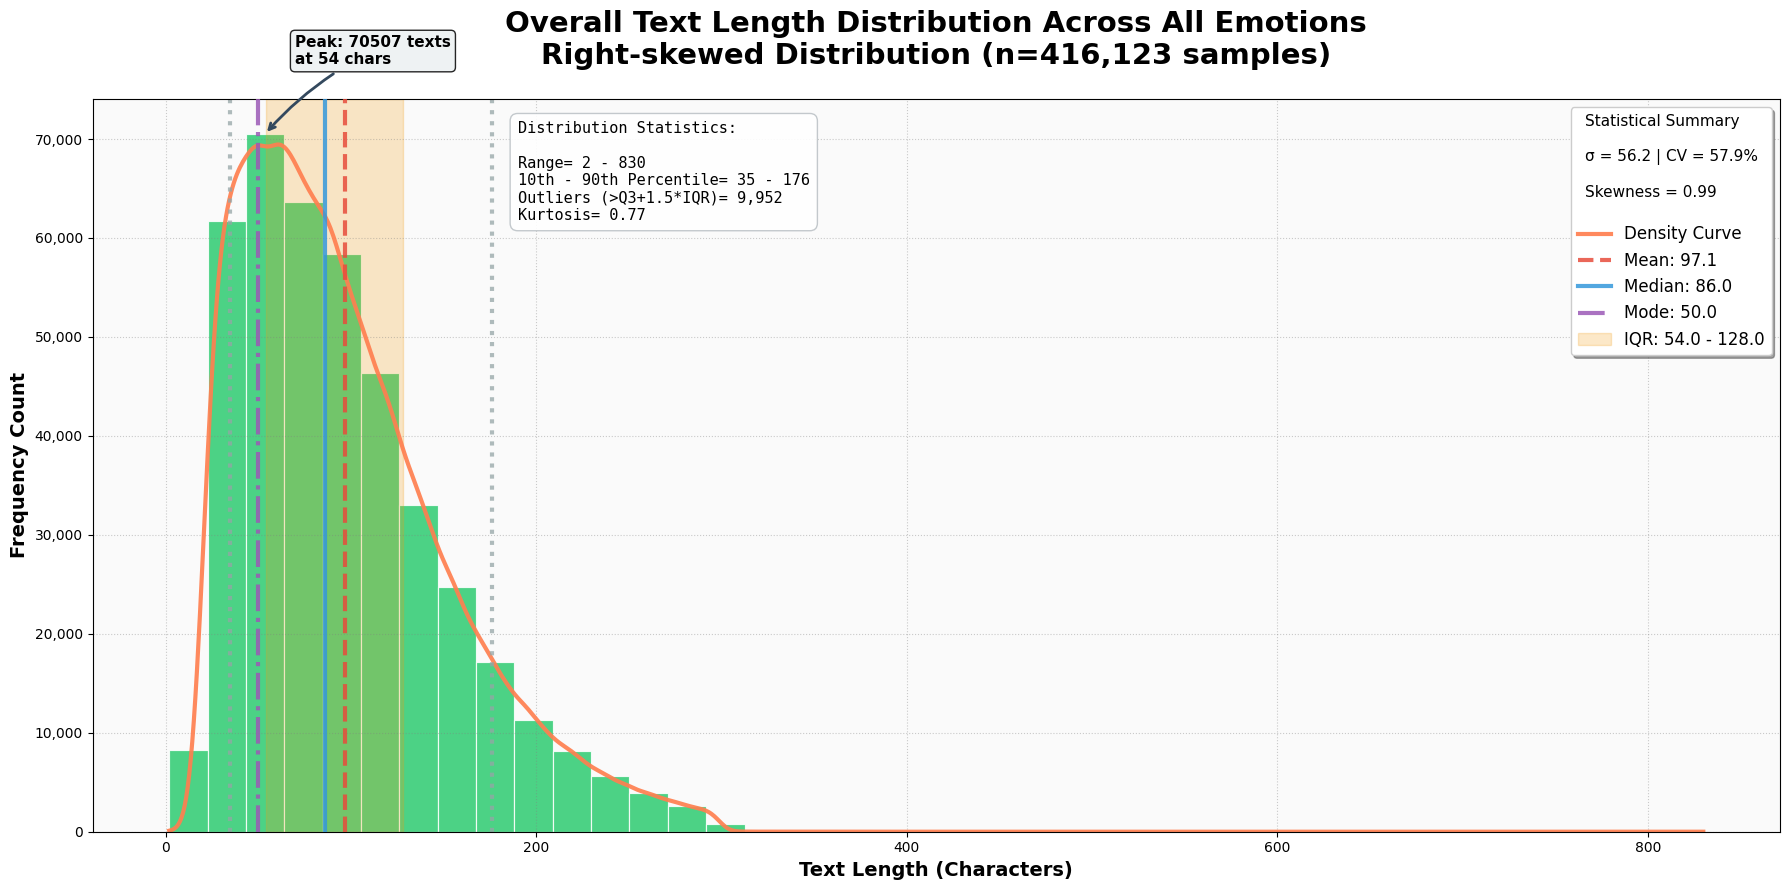

In [ ]:
# Create Enhanced Figure
plt.figure(figsize=(18,9))
plt.style.use("default")

# Calculate Comprehensive Statistics
data = df_analisis['text_length']
mean_len = data.mean()
median_len = data.median()
std_len = data.std()
q25 = data.quantile(0.25)
q75 = data.quantile(0.75)
mode_len = data.mode().iloc[0] if not data.mode().empty else median_len
skewness = data.skew()
kurtosis = data.kurtosis()
cv = (std_len/mean_len)*100 # Coefficient Variation


# Create The Main Histogram With Enhanced Styling
n, bins, patches = plt.hist(data, bins=40,
                            alpha=0.85, color='#2ecc71',
                            edgecolor='white',
                            linewidth=0.85, density=False)


# Add KDE Overlay
kde_x = np.linspace(data.min(), data.max(), 1000)
kde = stats.gaussian_kde(data)
kde_y = kde(kde_x) * len(data) * (bins[1] - bins[0])  # Scale to Match Histogram
plt.plot(kde_x, kde_y, color='coral',
         linewidth=3, alpha=0.92,
         label='Density Curve')


# Add Statistical Reference Lines With Enhanced Styling
plt.axvline(mean_len, color='#e74c3c', linestyle='--',
            linewidth=3, alpha=0.85,
            label=f'Mean: {mean_len:.1f}', zorder=5)
plt.axvline(median_len, color='#3498db', linestyle='-',
            linewidth=3, alpha=0.85,
            label=f'Median: {median_len:.1f}', zorder=5)
plt.axvline(mode_len, color='#9b59b6', linestyle='-.',
            linewidth=3, alpha=0.85,
            label=f'Mode: {mode_len:.1f}', zorder=5)


# Add Quartile Shading
plt.axvspan(q25, q75, alpha=0.23,
           color='#f39c12',
           label=f'IQR: {q25:.1f} - {q75:.1f}')


# Add Percentile Marker
p90 = data.quantile(0.9)
p10 = data.quantile(0.1)
plt.axvline(p10, color='#95a5a6',
            linestyle=':',
            linewidth=3,
            alpha=0.75)
plt.axvline(p90, color='#95a5a6',
            linestyle=':',
            linewidth=3,
            alpha=0.75)


# Enhanced Title With Statistical Context
distribution_type = "Right-skewed" if skewness > 0.5 else "Left-skewed" if skewness < -0.5 else "Approximately Normal"
plt.title(f'Overall Text Length Distribution Across All Emotions\n'
          f'{distribution_type} Distribution (n={len(data):,} samples)',
          fontsize=21, fontweight='bold', pad=25)


# Enhanced Axis Labels
plt.xlabel('Text Length (Characters)',
           fontsize=14, fontweight='semibold')
plt.ylabel('Frequency Count',
           fontsize=14, fontweight='semibold')


# # Format Axes For Better Readability
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))


# Enhanced Legend With Comprehensive Statistics
legend_title = (f'Statistical Summary\n\n'
                f'σ = {std_len:.1f} | CV = {cv:.1f}%\n\n'
                f'Skewness = {skewness:.2f}\n')
plt.legend(title=legend_title, loc='best',
           frameon=True, fancybox=True, shadow=True,
           fontsize=12, title_fontsize=11)


# Enhanced Grid
plt.grid(True, linestyle=':',
         alpha=0.4, color='gray')
plt.gca().set_facecolor('#fafafa')


# Add Comprehensive Statistics Text Box
stats_text = (f'Distribution Statistics:\n\n'
              f'Range= {data.min():.0f} - {data.max():.0f}\n'
              f'10th - 90th Percentile= {p10:.0f} - {p90:.0f}\n'
              f'Outliers (>Q3+1.5*IQR)= {len(data[data > q75 + 1.5 * (q75-q25)]):,}\n'
              f'Kurtosis= {kurtosis:.2f}')
plt.text(0.252, 0.97, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round,pad=0.5',
                   facecolor='white', alpha=0.9, edgecolor='#bdc3c7'),
         fontsize=11, fontfamily='monospace')



# Add Annotation For Peak
peak_idx = np.argmax(n)
peak_x = (bins[peak_idx] + bins[peak_idx + 1]) / 2
peak_y = n[peak_idx]
plt.annotate(f'Peak: {peak_y:.0f} texts\nat {peak_x:.0f} chars',
             xy=(peak_x, peak_y), xytext=(peak_x * 1.3, peak_y * 1.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.1',
                             color='#34495e', lw=2),
             bbox=dict(boxstyle='round,pad=0.3', facecolor='#ecf0f1',
                       alpha=0.85),
             fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Handling Outliers

### Statistical Analysis and Report by Handling Outliers

In [ ]:
print('\n'+'='*100)
print('Comprehensive Text Length Distribution Analysis')
print('='*100)

print(f'\nDataset Overview:')
print('\n')
print(f'Total Samples= {len(data):,}')
print(f'Unique Text Lengths= {data.nunique():,}')
print(f'Data Completeness= {(1 - data.isnull().sum() / len(data)) * 100:.1f}%')

print(f'\nCentral Tendency:')
print(f'Mean= {mean_len:.2f} characters')
print(f'Median= {median_len:.2f} characters')
print(f'Mode= {mode_len:.2f} characters')

print(f'\nVariability:')
print(f'Standard Deviation= {std_len:.2f} characters')
print(f'Variance= {std_len**2:.2f} characters')
print(f'Coefficient of Variation: {cv:.2f}%')
print(f'Range= {data.max() - data.min():.0f} characters')
print(f'Interquartile Range= {q75-q25:.2f} characters')


print(f'\nDistribution Shape:')
print(f"Skewness= {skewness:.3f} ({'Right-skewed' if skewness > 0.5 else 'Left-skewed' if skewness < -0.5 else 'Approximately Symmetric'})")
print(f"Kurtosis= {kurtosis:.3f} ({'Heavy-tailed' if kurtosis > 0 else 'Light-tailed'})")


print(f'\nPercentiles:')
percentiles = [10,25,50,75,90,95,99]
for p in percentiles:
  value = data.quantile(p/100)
  print(f'{p}th percentile: {value:.1f} characters')


print(f'\nOutlier Analysis:')
iqr = q75-q25
lower_fence = q25-1.5*iqr
upper_fence = q75+1.5*iqr
outlier_low = len(data[data < lower_fence])
outlier_high = len(data[data > upper_fence])
print(f'Lower Outliers (< {lower_fence:.1f}) = {outlier_low:,} ({outlier_low/len(data)*100:.1f}%)')
print(f'Upper Outliers (> {upper_fence:.1f}) = {outlier_high:,} ({outlier_high/len(data)*100:.1f}%) ')
print(f'Total Outliers = {outlier_low + outlier_high:,} ({(outlier_low + outlier_high)/len(data)*100:.1f}%)')
print('='*100)


Comprehensive Text Length Distribution Analysis

Dataset Overview:


Total Samples= 416,123
Unique Text Lengths= 333
Data Completeness= 100.0%

Central Tendency:
Mean= 97.10 characters
Median= 86.00 characters
Mode= 50.00 characters

Variability:
Standard Deviation= 56.18 characters
Variance= 3155.78 characters
Coefficient of Variation: 57.85%
Range= 828 characters
Interquartile Range= 74.00 characters

Distribution Shape:
Skewness= 0.987 (Right-skewed)
Kurtosis= 0.771 (Heavy-tailed)

Percentiles:
10th percentile: 35.0 characters
25th percentile: 54.0 characters
50th percentile: 86.0 characters
75th percentile: 128.0 characters
90th percentile: 176.0 characters
95th percentile: 209.0 characters
99th percentile: 267.0 characters

Outlier Analysis:
Lower Outliers (< -57.0) = 0 (0.0%)
Upper Outliers (> 239.0) = 9,952 (2.4%) 
Total Outliers = 9,952 (2.4%)


In [ ]:
def feature_outlier_analysis(df_analisis, feature, start=None, end=None, mode=0, save_filename=None):

  # ensure the feature exists in the DataFrame
  if feature not in df_analisis.columns:
    print(f"Feature '{feature}' Not Found in The DataFrame.")
    return

  # Set Deafult Start and End If Not Provided
  if start is None:
    start = int(df_analisis[feature].min())
  if end is None:
    end = int(df_analisis[feature].max())
  print(f"Analyzing Feature '{feature}' from {start} to {end}.")

  # Iterate Over The Specified Range
  for i in range(start, end + 1):
    subset = df_analisis[df_analisis[feature] == i]
    count = len(subset)
    print(f"Feature '{feature}' {i}: {count} entries.")

    # Save to CSV if Mode is Not Zero
    if mode != 0 and save_filename:
      subset.to_csv(save_filename, mode='a', index=False)   # append to the file
  print("Feature Outlier Analysis Completed.")

## 6. Data Visualization for Calculate Sentences Length

Summary Statistics by Label:
------------------------------------------------------------------------------
              count   mean  median    std  min  max
label_modif                                        
Anger         57235  19.05    17.0  11.27    1  178
Fear          47664  18.97    17.0  11.08    1   79
Joy          140779  19.56    18.0  10.90    1   94
Love          34497  20.83    19.0  11.15    3   71
Sadness      120989  18.50    16.0  11.00    1  101
Surprise      14959  19.76    18.0  11.02    3   66


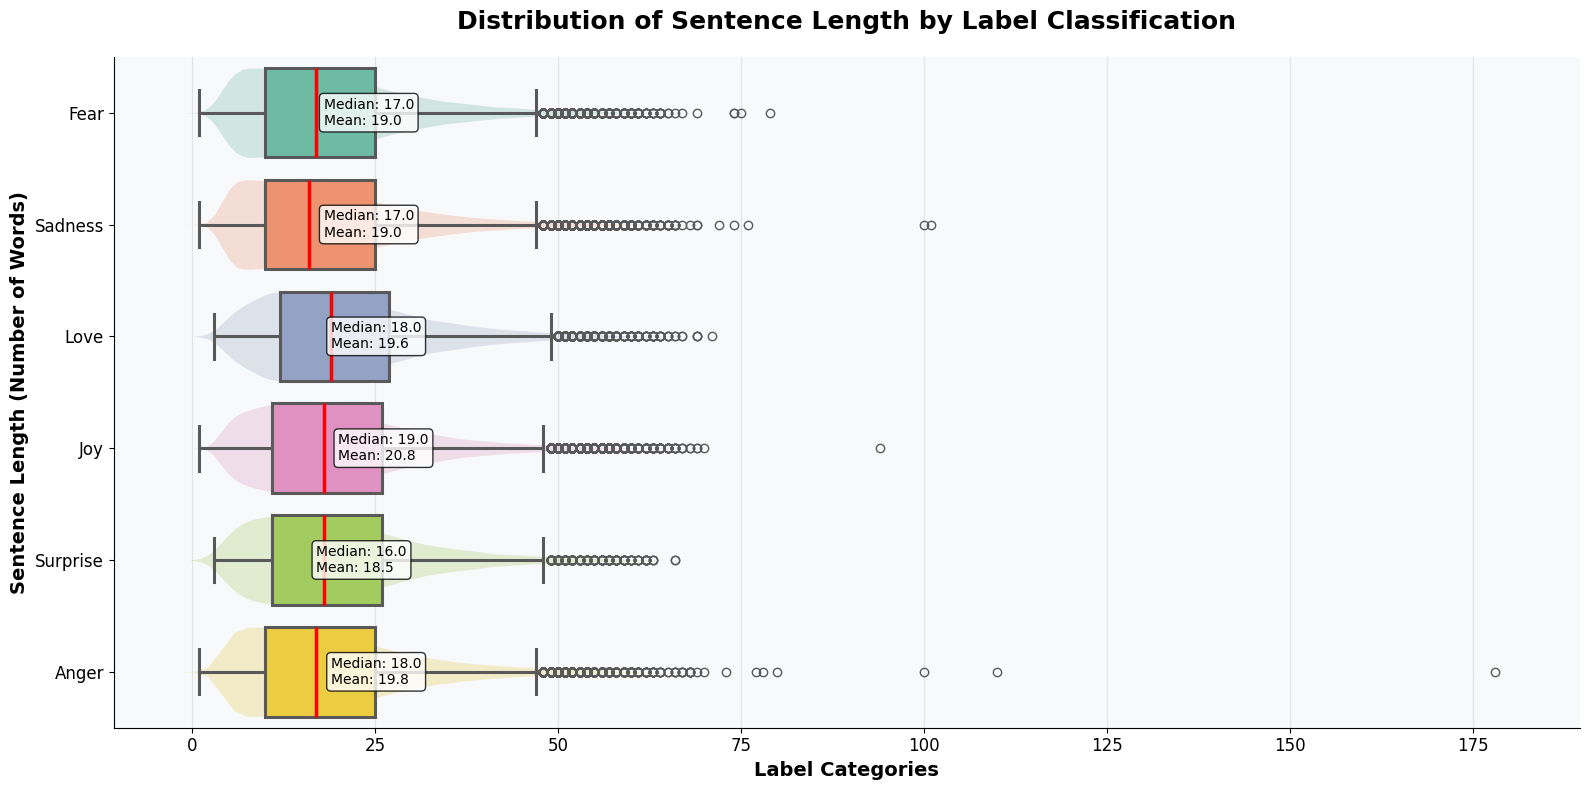

In [ ]:
# Calculate Sentences Length Using Vectorized String Operations
df_analisis['sentence_length'] = df_analisis['text'].str.split().str.len()

# Create the Enhanced Visualization
plt.figure(figsize=(16,8))
plt.style.use('default')  # reset to default style for consistency

# Create Boxplot With Enhanced Styling
ax = sns.boxplot(data=df_analisis,
                 x='sentence_length',
                 y='label_modif',
                 palette='Set2',
                 saturation=0.82,
                 linewidth=2.2,
                 boxprops=dict(linewidth=2.2),
                 capprops=dict(linewidth=2.2),
                 medianprops=dict(linewidth=2.5,
                                  color='red'))

# Add Violin Plot Overlay For Distribution Shape
sns.violinplot(data=df_analisis,
               x='sentence_length',
               y='label_modif',
               palette='Set2',
               alpha=0.28,
               inner=None,
               linewidth=0)

# Enhanced Title and Labels
plt.title('Distribution of Sentence Length by Label Classification',
          fontsize=18,
          fontweight='bold',
          pad=20)

plt.ylabel('Sentence Length (Number of Words)',
           fontsize=14,
           fontweight='bold')
plt.xlabel('Label Categories',
           fontsize=14,
           fontweight='bold')

# Add Grid For Better Readability
plt.grid(True, alpha=0.3, axis='x')


# Add Statistical Annotations
medians = df_analisis.groupby('label_modif')['sentence_length'].median()
means = df_analisis.groupby('label_modif')['sentence_length'].mean()


# Annotate With Median Values
for i, (label, median_val) in enumerate(medians.items()):
  mean_val = means[label]
  ax.text(median_val + 1, i, f'Median: {median_val:.1f}\nMean: {mean_val:.1f}',
          verticalalignment='center',
          bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
          fontsize=10)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Add a Subtle Background Color
ax.set_facecolor('#f8f9fa')

# Remove Top and Right Spines for  Cleaner Look
sns.despine()

# Adjust Layout
plt.tight_layout()


# Display Summary Statistics
print("Summary Statistics by Label:")
print('-'*78)
summary_stats = df_analisis.groupby('label_modif')['sentence_length'].agg(['count',
                                                                           'mean',
                                                                           'median',
                                                                           'std',
                                                                           'min',
                                                                           'max']).round(2)
print(summary_stats)
plt.show()

In [ ]:
def sentence_length_outlier(start=1, end=2, save_csv=False):
  outliers = {}
  for length in range(start, end):
    filtered_df = df_analisis[df_analisis['sentence_length'] == length]
    count = len(filtered_df)
    print(f'Sentence Length {length} Has {count} Occurences.')


    if count > 0:
      outliers[length] = filtered_df


      if save_csv:
        filename = f'df_sentence_length_{length}.csv'
        filtered_df.to_csv(filename, index=False)
        print(f'Saved {count} Record to {filename}')

  return outliers

In [ ]:
outlier_data = sentence_length_outlier(start=1, end=5, save_csv=True)

Sentence Length 1 Has 25 Occurences.
Saved 25 Record to df_sentence_length_1.csv
Sentence Length 2 Has 76 Occurences.
Saved 76 Record to df_sentence_length_2.csv
Sentence Length 3 Has 957 Occurences.
Saved 957 Record to df_sentence_length_3.csv
Sentence Length 4 Has 7539 Occurences.
Saved 7539 Record to df_sentence_length_4.csv


In [ ]:
# Define The Sentence Length tp Remove
lengths_to_remove = [1,2,3]

# Filtered the DataFrame to exclude these Lengths
df_analisis = df_analisis[~df_analisis['sentence_length'].isin(lengths_to_remove)].copy()

# Optionally, Reset The Index For CleanLiness
df_analisis.reset_index(drop=True, inplace=True)

# Optional: Save The Filtered DataFrame For Future Use
df_analisis.to_csv('df_analisis_sentence_length.csv', index=False)
print(f'Filtered DataFrame Saved With {len(df_analisis)} Records')

Filtered DataFrame Saved With 415065 Records


In [ ]:
df_analisis.shape

(415065, 5)

In [ ]:
df_analisis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415065 entries, 0 to 415064
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             415065 non-null  object
 1   label            415065 non-null  int64 
 2   label_modif      415065 non-null  object
 3   text_length      415065 non-null  int64 
 4   sentence_length  415065 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.8+ MB


In [ ]:
df_analisis.describe().T

,count,mean,std,min,25%,50%,75%,max
label,415065.0,1.554214,1.490597,0.0,0.0,1.0,3.0,5.0
text_length,415065.0,97.310221,56.096730,12.0,54.0,86.0,128.0,830.0
sentence_length,415065.0,19.266927,11.029826,4.0,11.0,17.0,25.0,178.0


In [ ]:
# Get The 10 Longest Sentences And Their Indices
top_sentences = df_analisis.sort_values(by='sentence_length', ascending=False).head(20)
top_indices = top_sentences.index
# Display The Top Sentences
print('Top 20 Longest Sentences:')
print(top_sentences[['text','sentence_length']])

Top 20 Longest Sentences:
                                                     text  sentence_length
347001  a few days back i was waiting for the bus at t...              178
290349  two years back someone invited me to be the tu...              110
97687   i have been thinking of changing my major for ...              101
38584   when i got into a bus i found that my wallet h...              100
22750   my living and working conditions at home were ...              100
332276  i had a dream i had a very close friend who ha...               94
249491  i worked with several classmates on a project ...               80
158527  i was camping in an old broken hut which had n...               79
56688   last semester when i dated a girl whom ive kno...               78
162121  i was a prefect at secondary school on the spo...               77
174240  when i was in lower six class during the summe...               76
387931  a boy phoned me at night and wanted to talk to...               75

In [ ]:
target_indices = [348392, 291479, 97990, 38708, 22827, 333596]
result = df_analisis.loc[target_indices].sort_values(by='sentence_length', ascending=False)
result

,text,label,label_modif,text_length,sentence_length
38708,ive been going up to brush my teeth at night a...,0,Sadness,241,44
22827,i feel hostile on edge always watching my ass ...,3,Anger,145,30
97990,i feel i am more in a phase of learning to be ...,2,Love,138,28
348392,i lack the natural ability to nurture without ...,3,Anger,81,14
333596,i do honestly feel that i will never experienc...,2,Love,69,12
291479,i do have one small question do the cows feel ...,0,Sadness,56,11


## 7. Data Cleaning

In [ ]:
html_tag_re = re.compile(r'<.*?>', re.DOTALL)
url_re = re.compile(r'https?://\S+')
numeric_re = re.compile(r'\d+')
non_alphanumeric_re = re.compile(r'[^a-zA-Z\s]')
extra_whitespace_re = re.compile(r'\s+')
emoji_re = re.compile("["
                      "\U0001F600-\U0001F64F"     # emoticons
                      "\U0001F300-\U0001F5FF"     # symbols & pictographs
                      "\U0001F680-\U0001F6FF"     # transport & map symbols
                      "\U0001F1E0-\U0001F1FF"     # flags (IOS)
                      "]+",
                      flags=re.UNICODE)

def processing_data(text):
  if pd.isnull(text) or not isinstance(text, str):
    return ""


  # Normalize Unicode Chars
  text = unicodedata.normalize('NFKD', text)

  # Remove HTML tags
  text = html_tag_re.sub('', text)

  # Remove URLs
  text = url_re.sub('', text)

  # Remove Emojis
  text = emoji_re.sub('', text)

  # Remove Numeric Values
  text = numeric_re.sub('', text)

  # Remove Non-aplhanumeric Characters (Excluding Spaces)
  text = non_alphanumeric_re.sub('', text)

  # Remove Extra Whitespaces
  text = extra_whitespace_re.sub(' ', text)

  # Convert to Lowerspace
  text = text.lower()

  # Strip Leading and Trailing Whitespace
  text = text.strip()


  return text

In [ ]:
df_analisis['text'] = df_analisis['text'].apply(processing_data)
df_analisis.head(10)

,text,label,label_modif,text_length,sentence_length
0,i just feel really helpless and heavy hearted,4,Fear,45,8
1,ive enjoyed being able to slouch about relax a...,0,Sadness,234,45
2,i gave up my internship with the dmrg and am f...,4,Fear,63,12
3,i dont know i feel so lost,0,Sadness,26,7
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,222,42
5,i was beginning to feel quite disheartened,0,Sadness,42,7
6,i would think that whomever would be lucky eno...,2,Love,125,25
7,i fear that they won t ever feel that deliciou...,1,Joy,124,25
8,im forever taking some time out to have a lie ...,5,Surprise,71,15
9,i can still lose the weight without feeling de...,0,Sadness,52,9


In [ ]:
def printData(data):
  for item in data:
    print(item)
printData(df_analisis['text'])

Output streaming akan dipotong hingga 5000 baris terakhir.
i cant say too much too soon but im just feeling really curious and really interested
im sorry i feel very strong about this
i feel that the dull cloud of fallout that still hangs over our country would shift anyone who is in any way tenuously attached
i just feel so helpless and it is making me feel physically sick about not being able to bring her home
i know im not supposed to say that and feel all tender and loving toward my sick little baby girl
i know how it feels to be blamed
i feel disgusted when need to act cute like the actions of gwiyomi
i feel damaged unworthy and incomplete
i feel freakin gorgeous today
i feel often balance vertigo life except i don t believe there has ever been a still point but instead a graceful dance upon a weaving and shifting landscape which lately has become a desperate race a battle and a rock opera on ice all at once
i feel accepted like i fit in which generates positivity makes me feel co

In [ ]:
# Calculate The Counts of Each Emotion
label_counts = df_analisis['label_modif'].value_counts()
label_percentages = df_analisis['label_modif'].value_counts(normalize=True)*100


# Create a DataFrame For Better Readability
label_distribution = pd.DataFrame({'Count': label_counts,
                                    'Percentage': label_percentages.round(2)})
print(label_distribution)

              Count  Percentage
label_modif                    
Joy          140474       33.84
Sadness      120694       29.08
Anger         57010       13.74
Fear          47510       11.45
Love          34443        8.30
Surprise      14934        3.60


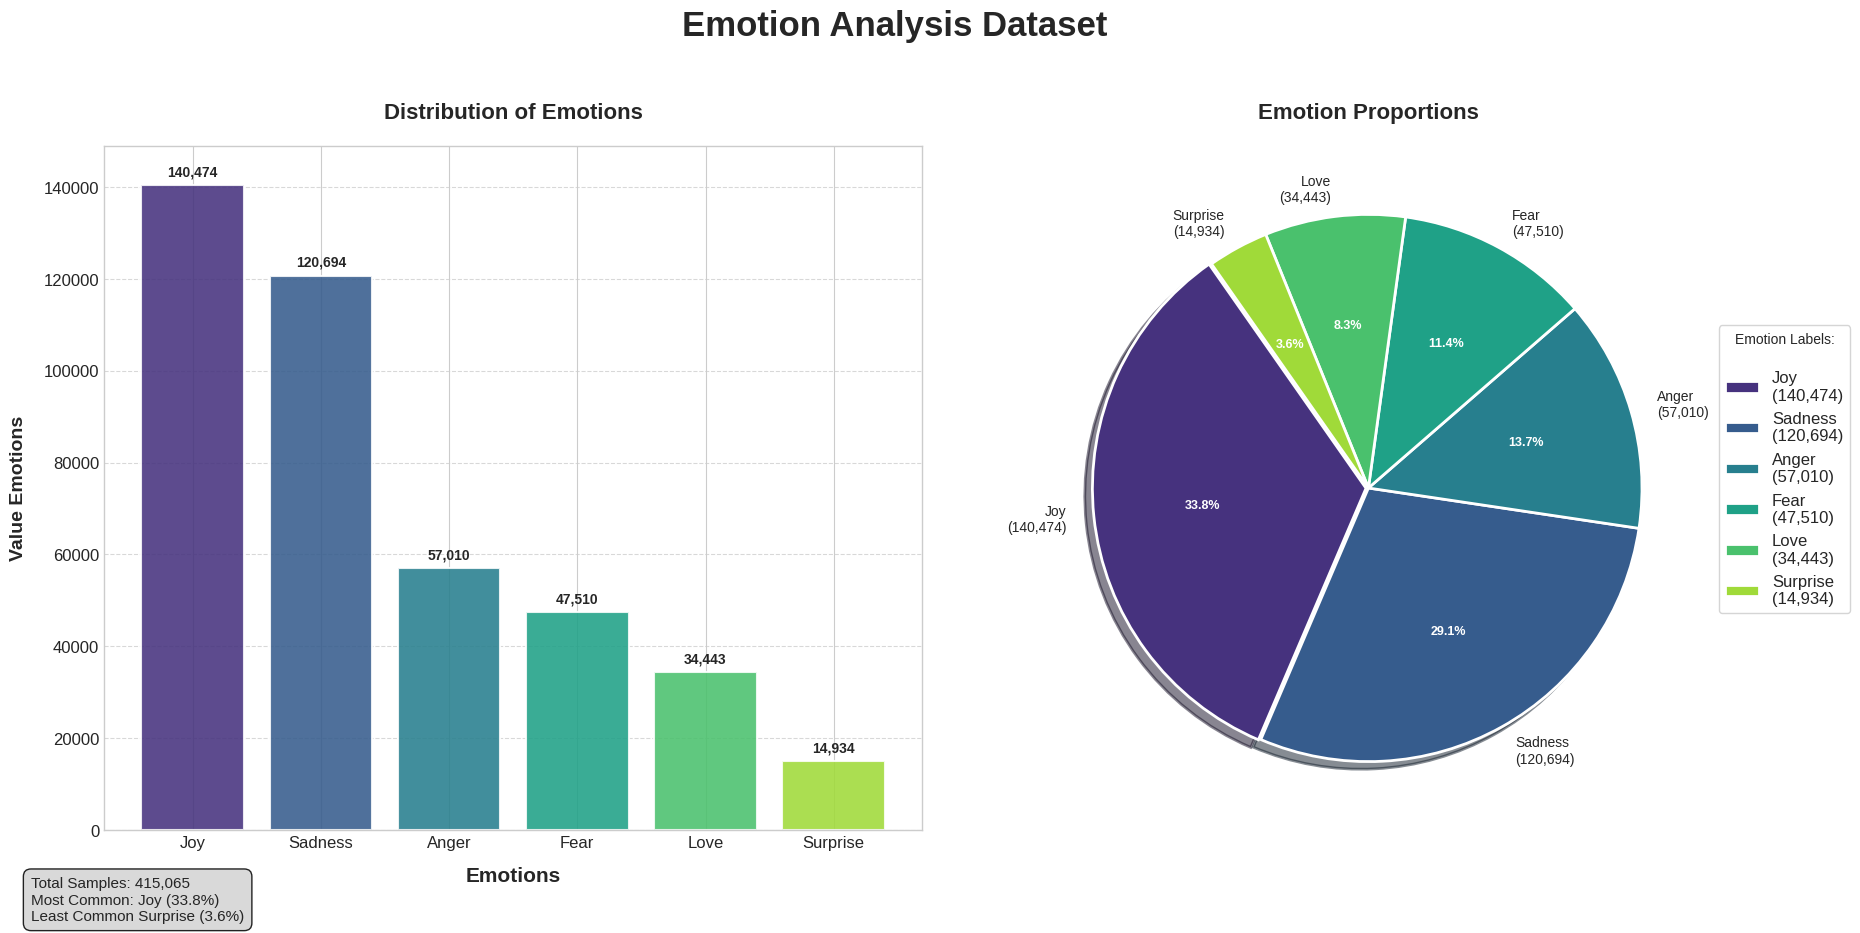

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,9))
plt.suptitle('Emotion Analysis Dataset',
             fontsize=25,
             fontweight='bold',
             y=1.032)
# Bar Chart for Left Plot
bars = ax1.bar(label_counts.index,
               label_counts.values,
               color=sns.color_palette('viridis',
                                       len(label_counts)),
               alpha=0.88,
               edgecolor='white',
               linewidth=1.5)

ax1.set_xlabel('Emotions',
               fontsize=15,
               fontweight='semibold',
               labelpad=12)
ax1.set_ylabel('Value Emotions',
               fontsize=14,
               fontweight='semibold',
               labelpad=12)
ax1.set_title('Distribution of Emotions',
              fontsize=16,
              fontweight='semibold',
              pad=20)
ax1.set_xticklabels(ax1.get_xticklabels(),
                    rotation=0,
                    ha='center',
                    fontsize=12)
ax1.tick_params(axis='y',
                labelsize=12)


# Add Value Labels on Bars With Better Positioning
for bar, value in zip(bars, label_counts.values):
  height = bar.get_height()
  ax1.text(bar.get_x() + bar.get_width()/2,
           height + max(label_counts.values) * 0.01,
           f'{value:,}',
           ha='center',
           va='bottom',
           fontweight='semibold')

ax1.grid(axis='y',
         linestyle='--',
         alpha=0.75,
         linewidth=0.8)
ax1.set_axisbelow(True)
ax1.set_ylim(0, max(label_counts.values) * 1.06)



# Pie Chart For Right Plot
total = sum(label_counts.values)
sizes = label_counts.values
labels = [f'{label}\n({count:,})' for label, count in zip(label_counts.index, label_counts.values)]


explode = [0.0088,0,0,0,0,0]
wedges, texts, autotexts = ax2.pie(sizes,
                                   labels=labels,
                                   autopct=lambda pct: f'{pct:.1f}%' if pct > 2 else '',
                                   startangle=125,
                                   explode=explode,
                                   colors=sns.color_palette('viridis', len(label_counts)),
                                   wedgeprops={'edgecolor': 'white', 'linewidth': 2},
                                   textprops={'fontsize': 10},
                                   shadow=True)

for autotext in autotexts:
  autotext.set_color('white')
  autotext.set_fontweight('bold')
  autotext.set_fontsize(9)

ax2.set_title('Emotion Proportions',
              fontsize=16,
              fontweight='bold',
              pad=20)

total_emotions = sum(label_counts.values)
most_common = label_counts.index[0]
most_common_pct = (label_counts.values[0] / total_emotions) * 100
least_common = label_counts.index[-1]
least_common_pct = (label_counts.values[-1] / total_emotions) * 100


# Add Text Box With Summary
summary_text = f'Total Samples: {total_emotions:,}\nMost Common: {most_common} ({most_common_pct:.1f}%)\nLeast Common {least_common} ({least_common_pct:.1f}%)'
fig.text(0.02, 0.02, summary_text,
         fontsize=11,
         bbox=dict(boxstyle='Round,pad=0.5', facecolor='lightgray', alpha=0.85))

plt.tight_layout()
plt.subplots_adjust(top=0.88, bottom=0.12)

fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.9)
plt.legend(loc='best', labels=labels,
           title='Emotion Labels:\n',
           bbox_to_anchor=(1, 0.75),
           fontsize=12,
           frameon=True)

plt.show()

## 8. Preprocessing Lemmatization and Filtering StopWords

In [ ]:
# Load model English Language (en_core_web_sm) dari spaCy dengan menonaktifkan komponen parser dan Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

nlp.max_length = 1_550_550      # meningkatkan batas panjang maksimum dokumen (1.550.500 karakter)

# fungsi untuk memproses teks (lematisasi dan penghapusan kata stopwords)
def process_text(doc):
  return ' '.join(token.lemma_ for token in doc
                  if not token.is_stop and token.is_alpha)


# fungsi yang dibuat untuk memproses daftar teks secara berurutan dengan batch
def process_texts_sequentially(texts, batch_size=550):
  processed_texts = []
  for doc in tqdm(nlp.pipe(texts,
                           batch_size=batch_size,
                           disable=['parser', 'ner']), total=len(texts), desc='Processing Texts'):
    processed_text = process_text(doc)
    processed_texts.append(processed_text)
  return processed_texts



# bagian utama untuk load data dan memulai pemrosesan data
if __name__ == "__main__":
  try:
    df_analisis
  except NameError:
    print("Error DataFrame 'df_analisis' is not defined. Please Load Your Data Before Processing.")
    exit()

  if 'text' not in df_analisis.columns:
    print("Error: The DataFrame Does Not Contain a 'text' Column.")
    exit()


  # menangani teks yang hilang (missing text)
  missing_texts = df_analisis['text'].isnull().sum()
  if missing_texts > 0:
    print(f'Warning: Found {missing_texts} Missing Texts. Filling Them With Empty Strings.')
    df_analisis['text'] = df_analisis['text'].fillna("")


  # mengonversikan kolom 'text' ke daftar dan memulai timer pemrosesan
  texts = df_analisis['text'].tolist()
  # Start The Processing Timer
  start_time = time.time()
  print(" Starting Text Processing...")


  # memproses teks dan menyimpan hasil ke kolom baru
  df_analisis['processed_text'] = process_texts_sequentially(texts, batch_size=550)

  # menghitung dan menampilkan waktu pemrosesan
  end_time = time.time()
  processing_time = end_time - start_time
  print(f' Processing Completed in {processing_time:.2f} seconds')

 Starting Text Processing...


Processing Texts: 100%|██████████| 415065/415065 [08:19<00:00, 830.58it/s] 


 Processing Completed in 499.78 seconds


## 9. Data Preparation For Pre Trained Model

In [ ]:
le = LabelEncoder()
df_analisis['label_encoded'] = le.fit_transform(df_analisis['label_modif'])

# Display The Mapping
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'Anger': np.int64(0), 'Fear': np.int64(1), 'Joy': np.int64(2), 'Love': np.int64(3), 'Sadness': np.int64(4), 'Surprise': np.int64(5)}


In [ ]:
# Check The Distribution of Labels
print(f'\nOriginal Label Distribution:')
print('\n')
print(df_analisis['label_modif'].value_counts())


Original Label Distribution:


label_modif
Joy         140474
Sadness     120694
Anger        57010
Fear         47510
Love         34443
Surprise     14934
Name: count, dtype: int64


In [ ]:
# Check The Distribution After label_encoded
print(f'\nAfter label_encoded Distribution:')
print('\n')
print(df_analisis['label_encoded'].value_counts())


After label_encoded Distribution:


label_encoded
2    140474
4    120694
0     57010
1     47510
3     34443
5     14934
Name: count, dtype: int64


In [ ]:
df_analisis

,text,label,label_modif,text_length,sentence_length,processed_text,label_encoded
0,i just feel really helpless and heavy hearted,4,Fear,45,8,feel helpless heavy hearted,1
1,ive enjoyed being able to slouch about relax a...,0,Sadness,234,45,ve enjoy able slouch relax unwind frankly need...,4
2,i gave up my internship with the dmrg and am f...,4,Fear,63,12,give internship dmrg feel distraught,1
3,i dont know i feel so lost,0,Sadness,26,7,not know feel lost,4
4,i am a kindergarten teacher and i am thoroughl...,4,Fear,222,42,kindergarten teacher thoroughly weary job have...,1
...,...,...,...,...,...,...,...
415060,i feel like telling these horny devils to find...,2,Love,132,26,feel like tell horny devil find site suited so...,3
415061,i began to realize that when i was feeling agi...,3,Anger,111,23,begin realize feel agitated restless thought dish,0
415062,i feel very curious be why previous early dawn...,5,Surprise,90,19,feel curious previous early dawn time don t se...,5
415063,i feel that becuase of the tyranical nature of...,3,Anger,222,41,feel becuase tyranical nature government el sa...,0


## 10. Data Splitting

In [ ]:
# memisahkan dataset menjadi data pelatihan dan data pengujian
x = df_analisis['processed_text'].values
y = df_analisis['label_encoded'].values

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.22, random_state=42, stratify=y)

print(f'Data Training Samples: {len(x_train)}')
print(f'Data Testing Samples: {len(x_test)}')

Data Training Samples: 323750
Data Testing Samples: 91315


In [ ]:
# membuat dataframe untuk data pelatihan dan data pengujian
train_df = pd.DataFrame({'text': x_train,
                         'label_modif': y_train})
test_df = pd.DataFrame({'text': x_test,
                        'label_modif': y_test})

# mengonversikan dataframe ke dataset Hugging face
# tujuan adalah memungkinkan integrasi yang lebih mudah dengan model dan pipeline dari hugging face
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print('Training Dataset:', train_dataset)
print('\nTesting Dataset:', test_dataset)

Training Dataset: Dataset({
    features: ['text', 'label_modif'],
    num_rows: 323750
})

Testing Dataset: Dataset({
    features: ['text', 'label_modif'],
    num_rows: 91315
})


## 11. Tokenization

In [ ]:
# Load tokenizer dari model pretrained
# tujuan menggunakan tokenizer dari model distilbert-base-uncased adalah untuk mengonversi teks mentah menjadi input numerik (token IDs) yang bisa diproses oleh model
model_name = 'distilbert-base-uncased'        # model ini adalah versi ringan dari BERT yang lebih cepat dengan performa hampir setara

# Initialize The Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# membuat fungsi tkenisasi
def tokenize_function(examples):
  return tokenizer(examples['text'],
                   padding='max_length',      # memastikan bahwa semua input memiliki panjang yang sama 128 token
                   truncation=True,           # memotong teks yang lebih panjang dari 128 token
                   max_length=128)  # Adjust based on your data (128 sudah cukup aman)

# menerapkan tokenisasi ke dataset
# map() yaitu mengaplikasikan fungsi tokenisasi ke setiap contoh dalam data sets
# batched=True yaitu memproses beberapa contoh sekaligus dalam satu batch untuk efisiensi
# batch_size=1000 adalah jumlah yang diproses dalam satu kali pemanggilan fungsi (dapat disesuaikan berdasarkan kapasitas memori anda)
train_dataset = train_dataset.map(tokenize_function, batched=True, batch_size=1000)
test_dataset = test_dataset.map(tokenize_function, batched=True, batch_size=1000)


# Rename The "label_modif" Column to "labels" As Expected by Hugging Face
# tujuan agar model transformer dari hugging face mengharapkan label dikolom "labels" secara default.
train_dataset = train_dataset.rename_column("label_modif", "labels")
test_dataset = test_dataset.rename_column("label_modif", "labels")


# mengatur format dataset untuk PyTorch
# tujuan agar konversi dataset hugging face ke format tensor PyTorch yang diperlukan saat dataset diberikan ke model saat training
train_dataset.set_format(type='torch',
                         columns=['input_ids',        # representasi numerik dari token dalam teks
                                  'attention_mask',   # menandai token mana yang merupakan bagian dari teks sebenarnya (1) dan mana yang hanya padding (0)
                                  'labels'])          # label target yang akan diprediksi oleh model
test_dataset.set_format(type='torch',
                        columns=['input_ids',
                                 'attention_mask',
                                 'labels'])

Map:   0%|          | 0/323750 [00:00<?, ? examples/s]

Map:   0%|          | 0/91315 [00:00<?, ? examples/s]

## 12. Model Initialization

In [ ]:
# Check CUDA
if torch.cuda.is_available():
  print('CUDA is Available. Training on GPU...')
else:
  print('CUDA is Not Available. Training on CPU...')

CUDA is Available. Training on GPU...


In [ ]:
num_labels = len(label_map)

In [ ]:
print(label_map)

{'Anger': np.int64(0), 'Fear': np.int64(1), 'Joy': np.int64(2), 'Love': np.int64(3), 'Sadness': np.int64(4), 'Surprise': np.int64(5)}


In [ ]:
# Load The pre_trained Model
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=num_labels)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _  = precision_recall_fscore_support(labels, preds, average='weighted')    # average='weighted untuk menghitung nilai rata-rata tertimbang untuk metrik, yang mempertimbangkan distribusi kelas dalam dataset.
  acc = accuracy_score(labels, preds)
  return {'Precision Score': precision,
          'Recall Score': recall,
          'F1-Score': f1,
          'Accuracy Score': acc}


# mengonfigurasikan argumen untuk pelatihan model menggunakan trainer dari hugging face
training_args = TrainingArguments(output_dir = './results',                 # Output Directory
                                  eval_strategy='epoch',                    # menentukan bahwa evaluasi dan penyimpanan model dilakukan setiap akhir epoch
                                  save_strategy='epoch',                    # menentukan bahwa evaluasi dan penyimpanan model dilakukan setiap akhir epoch
                                  learning_rate=7e-5,                       # menetapkan laju pembelajaran untuk optimizer.
                                  per_device_train_batch_size=32,           # menentukan ukuran batch untuk pelatihan dan evaluasi.
                                  per_device_eval_batch_size=32,            # menentukan ukuran batch untuk pelatihan dan evaluasi.
                                  num_train_epochs=3,                       # menetapkan jumlah epoch untuk pelatihan. nilai ini dapat disesuaikan berdasarkan konvergensi model
                                  weight_decay=0.01,                        # menetapkan kekutan dacay bobot untuk regularisasi L2.
                                  logging_dir='./logs',                     # Directory For Storing Logs
                                  logging_steps=100,                        # menentukan frekuensi langkah untuk mencatat log pelatihan
                                  load_best_model_at_end=True,              # memastikan bahwa model terbaik berdasarkan metrik evaluasi dimuat setelah pelatihan selesai
                                  metric_for_best_model='eval_F1-Score',
                                  greater_is_better=True)                   # menentukan bahwa model terbaik dipilih berdasarkan F1-score evaluasi dengan asumsi nilai yang lebih tinggi lebih baik

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initializer The Trainer
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  compute_metrics=compute_metrics)

# Check The Device Being Used By The Model
print('Training On:', trainer.args.device)

# Starting Training
trainer.train()

Training On: cuda:0


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: torusstars (torusstars-job-seekers) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision score,Recall score,F1-score,Accuracy score
1,0.132100,0.136882,0.933778,0.930745,0.927981,0.930745


Epoch,Training Loss,Validation Loss,Precision score,Recall score,F1-score,Accuracy score
1,0.132100,0.136882,0.933778,0.930745,0.927981,0.930745
2,0.102000,0.130982,0.941046,0.932782,0.934028,0.932782
3,0.096700,0.127483,0.936117,0.932924,0.933439,0.932924


TrainOutput(global_step=30354, training_loss=0.13136668860963377, metrics={'train_runtime': 10446.1555, 'train_samples_per_second': 92.977, 'train_steps_per_second': 2.906, 'total_flos': 3.216703468608e+16, 'train_loss': 0.13136668860963377, 'epoch': 3.0})

# 13. Evaluation Model

In [ ]:
# Evaluation The Model On The Testing Set
results = trainer.evaluate()
print('Evaluation Results:', results)

Evaluation Results: {'eval_loss': 0.13098205626010895, 'eval_Precision Score': 0.9410455064849023, 'eval_Recall Score': 0.9327821277993757, 'eval_F1-Score': 0.9340283035970044, 'eval_Accuracy Score': 0.9327821277993757, 'eval_runtime': 301.8653, 'eval_samples_per_second': 302.502, 'eval_steps_per_second': 9.455, 'epoch': 3.0}


In [ ]:
def plot_conf_matr(conf_matr, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):
  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (43, 10))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 0)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()

In [ ]:
pred = trainer.predict(test_dataset)
pred_labels = np.argmax(pred.predictions, axis=1)
true_labels = pred.label_ids
cm = confusion_matrix(true_labels, pred_labels)
# classification report
print('Classification Report:\n\n')
print(classification_report(true_labels, pred_labels, target_names=le.classes_))

Classification Report:


              precision    recall  f1-score   support

       Anger       0.98      0.90      0.94     12542
        Fear       0.93      0.86      0.89     10452
         Joy       0.99      0.91      0.95     30905
        Love       0.76      0.97      0.86      7578
     Sadness       0.94      0.99      0.97     26553
    Surprise       0.73      0.99      0.84      3285

    accuracy                           0.93     91315
   macro avg       0.89      0.94      0.91     91315
weighted avg       0.94      0.93      0.93     91315



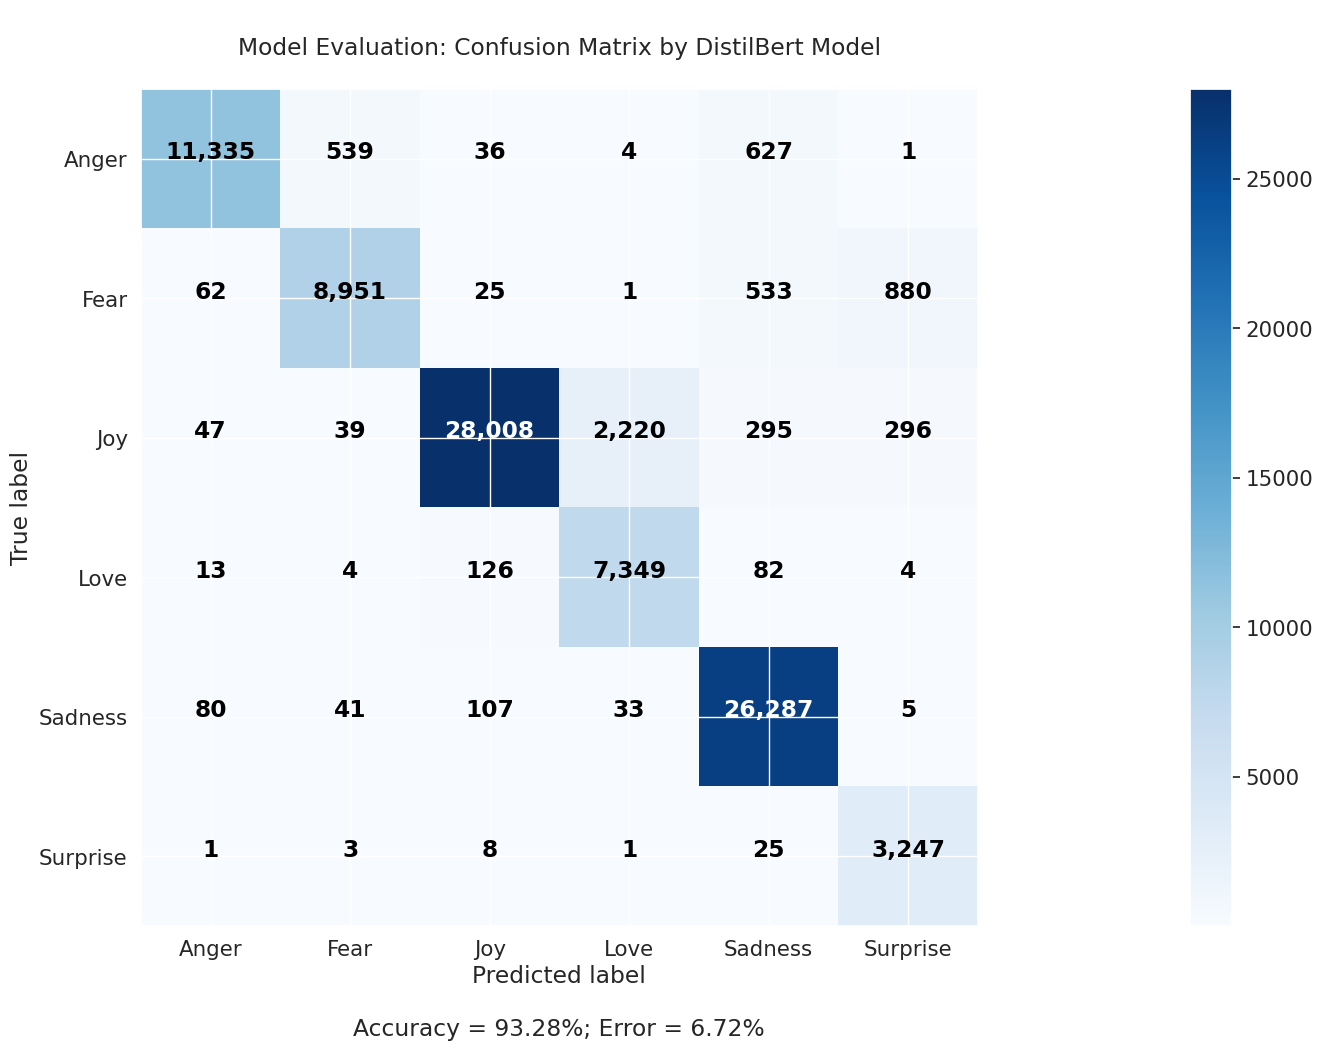

In [ ]:
plot_conf_matr(cm,
               classes=le.classes_,
               normalize=False,
               cmap='Blues',
               title='Model Evaluation: Confusion Matrix by DistilBert Model')

# 14. Prediction and Inference

In [ ]:
def predict_emotion(text):
  # Tokenize The Input text
  inputs = tokenizer(text,
                     return_tensors='pt',
                     padding=True,
                     truncation=True,
                     max_length=128)

  # Move inputs to the model's device
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)
  inputs = {k: v.to(device) for k, v in inputs.items()}


  # Get model predictions
  with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).cpu().numpy()[0]


  # map back to label
  emotion = le.inverse_transform([predicted_class]) [0]
  return emotion

In [ ]:
sample_text = "I cried seeing you couldn't do it."
predicted_emotion = predict_emotion(sample_text)
print(f"Sample Text: {sample_text}\nPredicted Emotion: {predicted_emotion}")

Sample Text: I cried seeing you couldn't do it.
Predicted Emotion: Anger


# 15. Save For Future Use

In [ ]:
# Save The Model and Tokenizer to a Directory
output_dir = "/content/saved_model"

# Ensure The Directory Exits
os.makedirs(output_dir, exist_ok=True)

# Save The Model
trainer.save_model(output_dir)

# save the Tokenizer
tokenizer.save_pretrained(output_dir)

print(f'Model and Tokenizer Saved to {output_dir}')

Model and Tokenizer Saved to /content/saved_model
